# Deep Reinforcement Learning

In this code, we implement the different DRL algorithms discussed in the thesis for different problems.

## General Imports

In [2]:
# Libraries needed to import for this example

import numpy as np                    # Basic numerical python library
import scipy as sci                   # Algorithms for scientific computing
import pandas as pd                   # Data analysis library
import random                         # Random number generator

from collections import deque         # Specialized contained datatypes

import matplotlib.pyplot as plt       # Plotting library for python

import gymnasium as gym               # Standard API for RL, with many environments

import torch                          # Deep Learning library
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

from stable_baselines3 import PPO, A2C # Reinforcement Learning library

import optuna                          # Hyperparameter search library
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

from typing import Literal, Optional, Union, Any, Dict # Type hints


In [9]:
# Function definitions

def tuple_or_list_to_str(list_tuple_list: list[Union[tuple, list]]) -> list[str]:
    
    # Store the elements of a list with tuples/lists into a list with strings.
    
    # Inputs

    # list_tuple_list : list[Union[tuple, list]] List of tuples/lists to store into a list of strs.
    
    # Outputs
    
    # list[str]: Elements of the tuple/list stored in a str.
    
    return list(map(lambda x: " ".join(map(str, x)), list_tuple_list))

def eps_greedy(state,net,epsilon):
    
    val = net.forward(torch.from_numpy(state.astype(np.float32)))
    
    if epsilon > np.random.rand():
        
        action = torch.randint(val.shape[0],[])
        
    else:
            
        action = torch.argmax(val)
            
    return action, val

# Environment class, needs to be a valid gym.Env class

class HTC_env(gym.Env):
    
    # Inputs
    
    # size: Number of layers of the physical system, we use 16
    
    # Initialization of the environment
    
    def __init__(self,size):

        super(HTC_env, self).__init__() # Initialize parent classes
        
        self.size = size # Number of layers of the physical system

        self.observation_space = gym.spaces.Box(0, 1, shape = (self.size,), dtype = int) # Shape of the possible states
        self.action_space = gym.spaces.Discrete(2*self.size) # Shape of the possibla actions

        self.render_mode = None # In case something asks about rendering the environment

        self._counter = 0 # Countdown to reset the episode
        self._max_counter = 2*self.size # Length of episode

        self.terminated = False # Checks if there is a need to reset the episode

        self.seen = []           # Holds the states that have been visited by this environment instance
        self.best = 0.0          # Holds the best state found of this environment instance
        self.seen_recording = [] # Holds how many states have been seen as the environment is used
        self.best_recording = [] # Holds which is the best state found yet, as the environment is used
        
    # Internal function to calculate the next state and return given an action
        
    def _take_action(self, action):

        new_state_slice = np.copy(self._current_state[0]) # Copy the previous state
    
        if action < self.size:
        
            new_state_slice[action] = int(0) # Make the selected layer dielctric
        
        else:
            
            new_state_slice[action-self.size] = int(1) # Make the selected layer metallic
    
        new_value = htc_series[tuple_or_list_to_str([new_state_slice.astype(int)])].values[0]/(norm) # HTC of the next state
    
        new_state = [new_state_slice,new_value] # New state tuple
        reward = new_value.astype('float') - rew_base # Reward from new state
        
        self._current_state = new_state # Save this state as current
    
        return new_state, reward
    
    
    # Function to reset the state after the episode ends
    
    def reset(self, seed = None, options = None):

        self.terminated = False # Reset the flag

        self._counter = 0 # Reset the countdown to reset the episode

        super().reset(seed=seed) # So that self.np_random is seeded, in case its needed

        self._reset_state = np.zeros((self.size,)).astype(int) # Seed for the starting state, all 0s
        
        self._current_state = [self._reset_state,htc_series[tuple_or_list_to_str([self._reset_state])].values[0]/(norm)] # Starting state, all 0s

        state = self._current_state[0] # Current state, back to 0
        HTC = self._current_state[1] # HTC of current state
        
        return state,{}

    # Function to apply an action and recover the next state and rewards
    
    def step(self, action):

        self._counter += 1 # Add one step to the counter

        if self._counter == self._max_counter+1: # If next step would be outside episode, time to reset

            next_state,_ = self.reset() # Reset episode
            reward = htc_series[tuple_or_list_to_str([next_state])].values[0]/(norm) - rew_base # What the reward would have been
            self.terminated = True # Put flag to true

        else:
            
            next_state, reward = self._take_action(action) # Apply action to obtain new state and reward

        if next_state[1] not in self.seen: # Check if it's a new state
            
            self.seen.append(next_state[1]) # Save the state to the list
            
            if next_state[1] > self.best: # If it's better than any before, save it as the best
                
                self.best = next_state[1]
                    
            self.seen_recording.append(len(self.seen)) # Save how many states we have seen so far
            self.best_recording.append(self.best) # Save which is the best among them

        return next_state[0], reward, self.terminated, False, {} # Output structure is the gym.Env structure
    
def act_on_env7(action, old_state, baseline):
    
    # Environment for the Reinforcement Learning Algorithm
    
    # Inputs
    
    # action: index describing the action to take: even index is a 0, odd ondex is a 1, in the floor(action/2) position
    # old_state: vector of 0s and 1s describing the material
    # baseline: HTC of the best system encountered so far, recorded in memory
    
    # Outputs
    
    # new_state: list of vector of 0s and 1s describing the material and the corresponding HTC
    # reward: HTC of the new system, minus the baseline
    
    new_state_slice = np.copy(old_state[0]) # Copy the previous state
    
    if action < n_slice:
        
        new_state_slice[action] = int(0) # Make the selected layer dielctric
        
    else:
            
        new_state_slice[action-n_slice] = int(1) # Make the selected layer metallic
    
    new_value = htc_series[tuple_or_list_to_str([new_state_slice.astype(int)])].values[0]/(norm) # HTC of the next state
    
    new_state = [new_state_slice,new_value] # New state tuple
    reward = (new_value.astype('float32') - baseline) # Reward from new state
    
    return new_state, reward

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros( 2*capacity - 1 )
        self.data = np.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx], dataIdx)

In [4]:
# Defining and loading the datasets

vect = np.genfromtxt('Datasets/16layers_index.txt').astype(int) # Combination of materials
htc_vals = np.genfromtxt('Datasets/16layer_data.txt', dtype = 'float64') # Associated HTC

htc_series = pd.Series(data = htc_vals, index = tuple_or_list_to_str(vect)) # Series form, for much faster searching

norm = 1e5 # Normalization constant for HTC, units (10^5 W/m^2 K)

base_seed = np.array([1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1]) # State to use as baseline for the rewards
rew_base = htc_series[tuple_or_list_to_str([base_seed.astype(int)])][0]/(norm) # Baseline for the rewards

/tmp/ipykernel_6655/2002588383.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rew_base = htc_series[tuple_or_list_to_str([base_seed.astype(int)])][0]/(norm) # Baseline for the rewards


## DRL Algorithms for RHT

In [ ]:
# SARSA

# Actions: component x is 0 if action is x in [0,n), component x is 1 if action is x+n in [n,2n)
# Reward: htc of next state

# Parameters

seed = 0 # Seed for the random variables

random.seed(seed) # Seed the random library
torch.manual_seed(seed) # Seed the pytorch library
np.random.seed(0) # Seed the numpy library

N_layers_data = 16 # Number of layers the system has

N_inputs = 16 # Number of elements on the input layer
N_layers = 4 # Number of hidden layers for the network
N_neurons = 64 # Number of neurons per layer
N_outputs = 32 # Number of elements on the output layer

lr = 1e-5 # Learning rate of the network
gamma = 0.99 # Discount factor

norm = 1e5 # Normalization for the htc values
start_state_seed = np.zeros((N_layers_data,)) # Starting state when resetting
start_state = [start_state_seed,htc_series[tuple_or_list_to_str([start_state_seed.astype(int)])][0]/(norm)]
baseline_seed = np.array([1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1]) # Baseline state 
baseline = [baseline_seed,htc_series[tuple_or_list_to_str([baseline_seed.astype(int)])][0]/(norm)]

eps0 = 1 # Initial epsilon for the epsilon greedy algorithm
eps1 = 0.1 # Final epsilon for the epsilon greedy algorithm
steps_eps = 60000 # Number of steps until epsilon reaches its final value

steps_training = 60000 # Number of training steps to perform on the network
len_episode = 32 # Length of an epsiode, after which it resets

# Pre-allocate variables

y_current = [] # Holds the current output of Q values
y_target = [] # Holds the predicted target Q values

loss_recording = [] # Records the loss for each training step
episode_recording = [] # Records the last state for trial episodes run greedily
best_recording = [] # Records the best state found so far

# Step 1: define the network

layers = [nn.Linear(N_inputs, N_neurons), nn.SELU()] # List of all the layers that will have the future network

for i in range(N_layers):
    
    layers.append(nn.Linear(N_neurons,N_neurons))
    layers.append(nn.SELU())

layers.append(nn.Linear(N_neurons,N_outputs)) 

q_net = nn.Sequential(*layers) # Network for behavior in Q
q_net_target = nn.Sequential(*layers) # Target network for Q

losss = nn.L1Loss() # Loss for the training of the network

opt = optim.Adam(q_net.parameters(), lr) # Optimizer to update the network

# Step 3: perform the training and exploration 

for i in range(steps_training): # Total number of explore-train loops
    
    state1 = start_state # Initialize to the reset state
    
    epsilon = np.maximum(eps0 - i*(eps0-eps1)/steps_eps,eps1) # Define the current value of epsilon, decays

    epsiode_recording = [] # Holds the states visited in this episode
        
    # Perform the exploration steps

    for j in range(len_episode):
    
        state = state1 # The current state is the ending state of the previous step
    
        # Choose an action given the state
    
        q_values = q_net.forward(torch.from_numpy(state[0].astype(np.float32))) # Prediction of Q values
    
        rand = random.uniform(0,1) # To do the random result
    
        if epsilon > rand:
        
            action = random.randint(0,2*N_layers_data-1) # Choose action randomly
        
        else:
            
            action = torch.argmax(q_values).item() # Choose action with highest Q 
        
        # Obtain the rewards and next state, given the state and action
    
        state1_seed = np.copy(state[0]) # Copy the current state
    
        if action < N_layers_data:
        
            state1_seed[action] = int(0) # The element becomes 0
        
        else:
        
            state1_seed[action-N_layers_data] = int(1) # The element becomes 1
        
        state1 = [state1_seed,htc_series[tuple_or_list_to_str([state1_seed.astype(int)])][0]/(norm)]
        
        reward = state1[1] - baseline[1]

        q_values1 = q_net.forward(torch.from_numpy(state[0].astype(np.float32))) # Prediction of Q values
    
        rand = random.uniform(0,1) # To do the random result
    
        if epsilon > rand:
        
            action1 = random.randint(0,2*N_layers_data-1) # Choose action randomly
        
        else:
            
            action1 = torch.argmax(q_values).item() # Choose action with highest Q 
    
        # Save the step to memory
    
        episode_recording.append([state,action,reward,state1,action1])
    
        if state1[1] > best_so_far[1]:
        
            best_so_far = state1 # Update the best state found 
        
        best_recording.append(best_so_far)
        
    # Perform the training steps
                    
    for j in range(len_batch):
            
        state_batch = episode_recording[j][0] # State of the given experience of the batch
        action_batch = episode_recording[j][1] # Action taken of the given experience of the batch
        reward_batch = episode_recording[j][2] # Reward obtained of the given experience of the batch
        state1_batch = episode_recording[j][3] # Next state of the given experience of the batch
        action1_batch = episode_recording[j][3] # Next action of the given experience of the batch
            
        # Obtain current value
            
        q_pred_current = q_net.forward(torch.from_numpy(state_batch[0].astype(np.float32)))
            
        # Obtain the Q values according to both networks
            
        q_pred = q_net.forward(torch.from_numpy(state1_batch[0].astype(np.float32)))
            
        # Predict the current Q value and target Q value
                        
        Q_target = torch.squeeze(torch.Tensor([reward_batch]) + gamma*q_pred[action1_batch]) # Calculate target Q
            
        # Save the values
            
        y_current.append(q_pred_current[action_batch])
        y_target.append(Q_target)
            
    # Calculate the loss
        
    loss = losss(torch.stack(y_current),torch.stack(y_target).detach())
    loss_recording.append(loss.item()) # Record the value of the loss
            
    # Update the network
        
    opt.zero_grad() # set gradients to 0
    loss.backward() # backpropagation
    opt.step() # gradient descent
                
    # Reset for next training step
        
    y_current = [] 
    y_target = [] 
        
    if i%10 == 0:
        
        state1_trial = start_state # Initialize to the reset state
        
        for j in range(len_episode):
            
            state_trial = state1_trial
            
            # Choose an action given the state
    
            q_values_trial = q_net.forward(torch.from_numpy(state_trial[0].astype(np.float32))) # Prediction of Q values
                                    
            action_trial = torch.argmax(q_values_trial).item() # Choose action with highest Q 
        
            # Obtain the rewards and next state, given the state and action
    
            state1_trial_seed = np.copy(state_trial[0]) # Copy the current state
    
            if action_trial < N_layers_data:
        
                state1_trial_seed[action_trial] = int(0) # The element becomes 0
        
            else:
        
                state1_trial_seed[action_trial-N_layers_data] = int(1) # The element becomes 1
        
            state1_trial = [state1_trial_seed,htc_series[tuple_or_list_to_str([state1_trial_seed.astype(int)])][0]/(norm)]
    
            reward_trial = state1_trial[1] - baseline[1]
        
        episode_recording.append(reward_trial + baseline[1])


In [ ]:
# DDQN

# Actions: component x is 0 if action is x in [0,n), component x is 1 if action is x+n in [n,2n)
# Reward: htc of next state

# Parameters

seed = 0 # Seed for the random variables

random.seed(seed) # Seed the random library
torch.manual_seed(seed) # Seed the pytorch library
np.random.seed(0) # Seed the numpy library

N_layers_data = 16 # Number of layers the system has

N_inputs = 16 # Number of elements on the input layer
N_layers = 4 # Number of hidden layers for the network
N_neurons = 64 # Number of neurons per layer
N_outputs = 32 # Number of elements on the output layer

lr = 1e-5 # Learning rate of the network
gamma = 0.99 # Discount factor

norm = 1e5 # Normalization for the htc values
start_state_seed = np.zeros((N_layers_data,)) # Starting state when resetting
start_state = [start_state_seed,htc_series[tuple_or_list_to_str([start_state_seed.astype(int)])][0]/(norm)]
baseline_seed = np.array([1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1]) # Baseline state 
baseline = [baseline_seed,htc_series[tuple_or_list_to_str([baseline_seed.astype(int)])][0]/(norm)]

eps0 = 1 # Initial epsilon for the epsilon greedy algorithm
eps1 = 0.1 # Final epsilon for the epsilon greedy algorithm
steps_eps = 60000 # Number of steps until epsilon reaches its final value

mem_size = 10000 # Size of the memory of states to save during training
N_prefill = 32 # Number of experiences to add to the memory before starting the training loop

steps_training = 60000 # Number of training steps to perform on the network
steps_double = 5000 # Number of training steps until update of target net, periodic
len_episode = 32 # Length of an epsiode, after which it resets
N_batch = 4 # Number of batches to take for training each time
len_batch = 32 # Number of experiences to include in a batch
n_explore = 4 # Number of steps to explore before training

# Pre-allocate variables

memory = deque([], maxlen = mem_size) # Memory of states, deque deletes the oldest one when maxlen is reached

y_current = [] # Holds the current output of Q values
y_target = [] # Holds the predicted target Q values

loss_recording = [] # Records the loss for each training step
episode_recording = [] # Records the last state for trial episodes run greedily
best_recording = [] # Records the best state found so far

# Step 1: define the network

layers = [nn.Linear(N_inputs, N_neurons), nn.SELU()] # List of all the layers that will have the future network

for i in range(N_layers):
    
    layers.append(nn.Linear(N_neurons,N_neurons))
    layers.append(nn.SELU())

layers.append(nn.Linear(N_neurons,N_outputs)) 

q_net = nn.Sequential(*layers) # Network for behavior in Q
q_net_target = nn.Sequential(*layers) # Target network for Q

losss = nn.L1Loss() # Loss for the training of the network

opt = optim.Adam(q_net.parameters(), lr) # Optimizer to update the network

# Step 2: populate the memory with some examples

state1 = start_state # Initialize to the reset state

for i in range(N_prefill):
    
    state = state1 # The current state is the ending state of the previous step
    
    # Choose an action given the state
            
    action = random.randint(0,2*N_layers_data-1) # Choose action with highest Q (random for the prefill)
        
    # Obtain the rewards and next state, given the state and action
    
    state1_seed = np.copy(state[0]) # Copy the current state
    
    if action < N_layers_data:
        
        state1_seed[action] = int(0) # The element becomes 0
        
    else:
        
        state1_seed[action-N_layers_data] = int(1) # The element becomes 1
        
    state1 = [state1_seed,htc_series[tuple_or_list_to_str([state1_seed.astype(int)])][0]/(norm)]
    
    reward = state1[1] - baseline[1]
    
    # Save the step to memory
    
    memory.append([state,action,reward,state1])
    
    if state1[1] > best_so_far[1]:
        
        best_so_far = state1 # Update the best state found 

# Step 3: perform the training and exploration 

state1 = start_state # Initialize to the reset state

episode_counter = 0 # Count until the episode resets

for i in range(steps_training): # Total number of explore-train loops
    
    if i%steps_double == 0:
        
        q_net_target.load_state_dict(q_net.state_dict()) # Copy the current state of the net onto the target net
                
    epsilon = np.maximum(eps0 - i*(eps0-eps1)/steps_eps,eps1) # Define the current value of epsilon, decays
        
    # Perform the exploration steps

    for j in range(n_explore):
    
        state = state1 # The current state is the ending state of the previous step
    
        # Choose an action given the state
    
        q_values = q_net.forward(torch.from_numpy(state[0].astype(np.float32))) # Prediction of Q values
    
        rand = random.uniform(0,1) # To do the random result
    
        if epsilon > rand:
        
            action = random.randint(0,2*N_layers_data-1) # Choose action randomly
        
        else:
            
            action = torch.argmax(q_values).item() # Choose action with highest Q 
        
        # Obtain the rewards and next state, given the state and action
    
        state1_seed = np.copy(state[0]) # Copy the current state
    
        if action < N_layers_data:
        
            state1_seed[action] = int(0) # The element becomes 0
        
        else:
        
            state1_seed[action-N_layers_data] = int(1) # The element becomes 1
        
        state1 = [state1_seed,htc_series[tuple_or_list_to_str([state1_seed.astype(int)])][0]/(norm)]
        
        reward = state1[1] - baseline[1]
    
        # Save the step to memory
    
        memory.append([state,action,reward,state1])
    
        if state1[1] > best_so_far[1]:
        
            best_so_far = state1 # Update the best state found 
        
        best_recording.append(best_so_far)
    
        # Counter for the episode
    
        episode_counter += 1
        
        if episode_counter == len_episode: # End of episode, reset to start
        
            episode_counter = 0
        
            state1 = start_state 
        
    # Perform the training steps
    
    for j in range(N_batch): # Number of batches
        
        batch_content = random.sample(memory, len_batch) # Obtain the batch
        
        for k in range(len_batch):
            
            state_batch = batch_content[k][0] # State of the given experience of the batch
            action_batch = batch_content[k][1] # Action taken of the given experience of the batch
            reward_batch = batch_content[k][2] # Reward obtained of the given experience of the batch
            state1_batch = batch_content[k][3] # Next state of the given experience of the batch
            
            # Obtain current value
            
            q_pred_current = q_net.forward(torch.from_numpy(state_batch[0].astype(np.float32)))
            
            # Obtain the Q values according to both networks
            
            q_pred = q_net.forward(torch.from_numpy(state1_batch[0].astype(np.float32)))
            q_pred_tar = q_net_target.forward(torch.from_numpy(state1_batch[0].astype(np.float32)))
            
            # Predict the current Q value and target Q value
            
            best_option = torch.argmax(q_pred).item() # Choose a' action
            
            Q_target = torch.squeeze(torch.Tensor([reward_batch]) + gamma*q_pred_tar[best_option]) # Calculate target Q
            
            # Save the values
            
            y_current.append(q_pred_current[action_batch])
            y_target.append(Q_target)
            
        # Calculate the loss
        
        loss = losss(torch.stack(y_current),torch.stack(y_target).detach())
        loss_recording.append(loss.item()) # Record the value of the loss
            
        # Update the network
        
        opt.zero_grad() # set gradients to 0
        loss.backward() # backpropagation
        opt.step() # gradient descent
                
        # Reset for next training step
        
        y_current = [] 
        y_target = [] 
        
    if i%10 == 0:
        
        state1_trial = start_state # Initialize to the reset state
        
        for j in range(len_episode):
            
            state_trial = state1_trial
            
            # Choose an action given the state
    
            q_values_trial = q_net.forward(torch.from_numpy(state_trial[0].astype(np.float32))) # Prediction of Q values
                                    
            action_trial = torch.argmax(q_values_trial).item() # Choose action with highest Q 
        
            # Obtain the rewards and next state, given the state and action
    
            state1_trial_seed = np.copy(state_trial[0]) # Copy the current state
    
            if action_trial < N_layers_data:
        
                state1_trial_seed[action_trial] = int(0) # The element becomes 0
        
            else:
        
                state1_trial_seed[action_trial-N_layers_data] = int(1) # The element becomes 1
        
            state1_trial = [state1_trial_seed,htc_series[tuple_or_list_to_str([state1_trial_seed.astype(int)])][0]/(norm)]
    
            reward_trial = state1_trial[1] - baseline[1]
        
        episode_recording.append(reward_trial + baseline[1])


In [ ]:
# REINFORCE algorithm

# Step 1: pre-allocating, loading and previous steps

# Defining and loading the datasets

vect = np.genfromtxt('16layers_index.txt').astype(int) # Combination of materials
htc_vals = np.genfromtxt('16layer_data.txt', dtype = 'float64') # Associated HTC

htc_series = pd.Series(data = htc_vals, index = tuple_or_list_to_str(vect)) # Series form, for much faster searching

# Fix the random seed

seed = 42

random.seed(seed) # Seed the random library
torch.manual_seed(seed) # Seed the pytorch library
np.random.seed(int(seed)) # Seed the numpy library

# NN hyperparameters

n_hidden = 4 # number of hidden layers
n_neurons = 64 # number of neurons per layer
lr = 0.00003 # NN learning rate

# RL hyperparameters

n_slice = 16 # Number of modifiable layers
norm = 1e5 # Normalization constant for HTC, units (10^5 W/m^2 K)

gamma = 0.99 # Discount rate

n_steps = n_slice*2 # Length of each episode
n_episode = 100000 # Number of episodes to train for

# Initializations and Preallocations

b = 0.0 # Baseline to subtract from the return

base_seed = np.array([1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1]) # State to use as baseline for the rewards
rew_base = htc_series[tuple_or_list_to_str([base_seed.astype(int)])][0]/(norm) # Baseline for the rewards

start_seed = np.zeros((n_slice,)) # State to use as starting point for each episode
start_state = [start_state_seed,htc_series[tuple_or_list_to_str([start_seed.astype(int)])][0]/(norm)] # Reset each episode
   
best_so_far = start_state[1] # Holds the best state found so far

log_probs = [] # Will hold the log of the probabilities
rewards = [] # Will hold the rewards for checking
seen_so_far = [] # Will hold a list of all the states found in a training run

last_state_record = [] # Will hold the last state of each episode
best_state_record = [] # Will hold the best state found until up to episode
loss_record = [] # Will hold the loss of each episode
all_rewards_sum = [] # Will hold the sum of all rewards in each episode

# Step 2: create the NN

in_dim = n_slice # Number of neurons in the input layer
out_dim = 2*n_slice # NUmber of neurons in the output layer

layers = [nn.Linear(in_dim, n_neurons), nn.SELU()] # Create a list of all the layers, starting with input

for i in range(n_hidden): # Include the hidden layers
        
    layers.append(nn.Linear(n_neurons,n_neurons))
    layers.append(nn.SELU())
    
layers.append(nn.Linear(n_neurons,out_dim)) # Add the output layer
    
pi = nn.Sequential(*layers) # Create the final NN
    
opt = optim.Adam(pi.parameters(), lr) # Define the optimizer

# Step 3: train the policy network

for eps in range(n_episode):
    
    state = start_state # Reset the environment each episode
    
    for t in range(n_steps): 
        
        # a) Choose the action given the state
            
        pdparam = pi.forward(torch.from_numpy(state[0].astype(np.float32))) # Forward pass, obtain output
        pd = Categorical(logits = pdparam) # Obtain a probability distribution over the variables using the output
        action = pd.sample() # Choose an action from the policy distribution
        log_probss = pd.log_prob(action) # Obtain the log_prob of the chosen action
        log_probs.append(log_probss) # Save the log_prob for the loss
        
        # b) Obtain the next state and reward from the action
                    
        state, reward = act_on_env7(action.item(), state, rew_base) # Response from environment
        rewards.append(reward) # Save the reward for checking
        
        if state[1] not in seen_so_far: # Check if it's a new state
            
            seen_so_far.append(state[1]) # Save the state to the list
            
            if state[1] > best_so_far: # If it's better than any before, save it as the best
                
                best_so_far = state[1]
                    
    last_state_record.append(state[1]) # Save the last state HTC for monitoring
    best_state_record.append(best_so_far) # Save the best state for monitoring
    
    total_reward = sum(rewards) # Sum of rewards of the episode
    all_rewards_sum.append(total_reward) # Save the sum of all rewards for monitoring

    # c) Obtain the loss
        
    returnss = np.empty(n_steps, dtype = np.float32) # Will hold all the returns
    next_ret = 0.0 
    
    for t in reversed(range(n_steps)): # From last to first, we compute backwards the sum to get each return
            
        next_ret = rewards[t] + gamma*next_ret
        returnss[t] = next_ret
        
    b = np.mean(returnss) # Baseline: average of the returns of the episode
    returnss = returnss - b # Returns with baseline
    returnss = torch.tensor(returnss) # Turn into a pytorch tensor
    
    log_props = torch.stack(log_probs) # Obtain the tensors from the list
    
    loss = -log_props*returnss # Calculate the gradient term, negative for maximization
    
    loss = torch.sum(loss) # Obtain the final loss
    
    loss_record.append(loss.item()) # Save the loss for monitoring
    
    opt.zero_grad() # Reset the gradients
    loss.backward() # Backpropagation
    opt.step() # Gradient descent (ascent)
        
    # clear memory for next episode
        
    log_probs = [] 
    rewards = [] 

In [ ]:
# Optuna

# We choose A2C for the search, almost the same code is valid for PPO

# Step 1: hyperparameters of the optuna search, random seeding and preallocations

N_TRIALS = 100  # Maximum number of trials
N_TIMESTEPS = int(1e5)  # Training budget
N_EVAL_EPISODES = 32 # Length of each evaluation episode
N_STARTUP_TRIALS = 5  # Stop random sampling after N_STARTUP_TRIALS
TIMEOUT = int(60 * 30 * 8)  # How long to wait for until stopping, in seconds

seed = 42 # Random seed

random.seed(seed) # Seed the random library
torch.manual_seed(seed) # Seed the pytorch library
np.random.seed(int(seed)) # Seed the numpy library

# Dictionary that holds the hyperparameters that all trials will share and never explore

DEFAULT_HYPERPARAMS = {  
    "policy": "MlpPolicy",
    "env": HTC_env(16),
    "use_rms_prop":False, # Delete in case of PPO
}

# Step 2: define external functions: evaluation of the model, sampling of hyperparams and the goal of the search

# Function 1: evaluation for the performance of the model: stop and run 10 episodes, then average over them

def custom_evaluation(env,model,len_eps):

    # Will return the mean last reward of an episode

    last_rewards = np.zeros((10,))

    # Step 1: reset the environment

    obs_evals,_ = env.reset()

    # Step 2 (repeated 10 times): train the model for an episode, record the last reward

    for i in range(10):

        for j in range(len_eps):
            
            action,_ = model.predict(obs_evals)
            obs_evals,reward_evals,_,_,_ = env.step(action)

        last_rewards[i] = reward_evals
        obs_evals,_ = env.reset()

    # Step 3: return the mean of the last rewards

    return np.mean(last_rewards)

# Function 2: parameter sampling for optuna

def sample_a2c_params(trial: optuna.Trial) -> Dict[str, Any]:

    # Hyperparameters we are searching for
    
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 5.0, log=True)
    
    gae_lambda = trial.suggest_float("gae_lambda",0.0,1.0)

    learning_rate = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    #activation_fn = trial.suggest_categorical("activation_fn", ["selu"])
    
    # Hyperparameters we will leave fixed
    
    activation_fn = nn.SELU
    net_arch = {"pi": [100,100,100,100], "vf": [100,100,100,100]}
    n_steps = 2 ** 5

    # Display true values
    
    trial.set_user_attr("gamma_", gamma)
    trial.set_user_attr("n_steps", n_steps)

    # Return dictionary with all chosen hyperparameters
    
    return {
        "n_steps": n_steps,                 # Steps per episode
        "gamma": gamma,                     # Discount factor for RL
        "learning_rate": learning_rate,     # Learning rate
        "max_grad_norm": max_grad_norm,     # Maximum gradient
        "gae_lambda": gae_lambda,           # GAE exponential factor
        #"batch_size": n_steps,             # Size of the batches considered # Add in case of PPO
        "policy_kwargs": {
            "net_arch": net_arch,           # Network architecture (actor and critic)
            "activation_fn": activation_fn, # Activation function
        },
    }

# Function 3: objective for optuna to search and evaluate configurations
# Given a configuration, it will sample hyperparameters, evaluate it and report the result 

def objective(trial: optuna.Trial) -> float:
    
    # 1. Sample hyperparameters and update the keyword arguments, adding the new ones to the default
    
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_a2c_params(trial))

    # Create the RL model
    
    model = A2C(**kwargs)

    # 2. Create envs used for evaluation 

    eval_env =  HTC_env(16)

    # 3. Train the model
    
    model.learn(N_TIMESTEPS)
    
    # 4. Evaluate the trained model
    
    score = custom_evaluation(eval_env,model,N_EVAL_EPISODES)
    
    model.env.close() # Reset environment
    eval_env.close()  # Reset environment

    return score

# Step 3: Perform the optuna search

# Set pytorch num threads to 1 for faster training

torch.set_num_threads(1)

# Select the sampler, can be random, TPESampler, CMAES, ...

sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)

# Do not prune before 1/5 of the max budget is used

pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_TIMESTEPS//5)

# Create the study and start the hyperparameter optimization

study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")

try:
    study.optimize(objective, n_trials=N_TRIALS, n_jobs=1, timeout=TIMEOUT)
    
except KeyboardInterrupt:
    
    pass

# Step 4: print results

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial #(.trials for all of them)

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print(f"    {key}: {value}")

In [ ]:
# A2C

# Step 1: pre-allocating, loading and previous steps

seed = 42 # Fix the random seed

random.seed(seed) # Seed the random library
torch.manual_seed(seed) # Seed the pytorch library
np.random.seed(int(seed)) # Seed the numpy library

torch.backends.cudnn.deterministic = True # Set cuda parameters
torch.backends.cudnn.benchmark = False    # Set cuda parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

n_eval_episodes = 32 # Number of steps per evaluation episode
N_timesteps = int(4000*32) # Number of steps (4000 episodes of 32 steps each)

torch.set_num_threads(1) # Set pytorch num threads to 1 for faster training

# Step 2: set the environment and the model hyperparameters

our_env = HTC_env(16) # Set environment (using the custom class)

# Hyperparameters chosen by optuna

n_steps = 2 ** 5                                                # Steps per episode
gamma = 1.0 - 0.05354748279639477                               # Discount factor for RL
learning_rate = 0.0003529867715614526                           # Learning rate
gae_lambda = 0.9972303247713417                                 # GAE exponential factor
max_grad_norm = 1.2858503485554726                              # Maximum gradient
net_arch = {"pi": [100,100,100,100], "vf": [100,100,100,100]}   # Network architecture (actor and critic)
activation_fn = nn.SELU                                         # Activation function

# Hyperparameter dictionary

DEFAULT_HYPERPARAMS = {
"policy": "MlpPolicy",
"env": our_env,
"use_rms_prop": False,
"device": device
}

Hyperparams = {
"n_steps": n_steps,
"gamma": gamma,
"learning_rate": learning_rate,
"max_grad_norm": max_grad_norm,
"gae_lambda": gae_lambda,
"policy_kwargs": {
    "net_arch": net_arch,
    "activation_fn": activation_fn,
    }
}

kwargs = DEFAULT_HYPERPARAMS.copy() # Start the dictionary with the default ones
kwargs.update(Hyperparams)          # Add the ones found by optuna 

# Step 3: train the model

model = A2C(**kwargs) # Create the model, using the previous hyperparams

model.learn(N_timesteps) # Train the model
    
model.env.close() # Close the env

In [ ]:
# PPO

# Step 1: pre-allocating, loading and previous steps

seed = 42 # Fix the random seed

random.seed(seed) # Seed the random library
torch.manual_seed(seed) # Seed the pytorch library
np.random.seed(int(seed)) # Seed the numpy library

torch.backends.cudnn.deterministic = True # Set cuda parameters
torch.backends.cudnn.benchmark = False    # Set cuda parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

n_eval_episodes = 32 # Number of steps per evaluation episode
N_timesteps = int(4000*32) # Number of steps (4000 episodes of 32 steps each)

torch.set_num_threads(1) # Set pytorch num threads to 1 for faster training

# Step 2: set the environment and the model hyperparameters

our_env = HTC_env(16) # Set environment (using the custom class)

# Hyperparameters chosen by optuna

n_steps = 2 ** 5                                                # Steps per episode
gamma = 1.0 - 0.00012343188973544484                            # Discount factor for RL
learning_rate = 6.24161237241945e-05                            # Learning rate
gae_lambda = 0.8714387482390391                                 # GAE exponential factor
max_grad_norm = 4.042358248277151                               # Maximum gradient
net_arch = {"pi": [100,100,100,100], "vf": [100,100,100,100]}   # Network architecture (actor and critic)
activation_fn = nn.SELU                                         # Activation function

# Hyperparameter dictionary

DEFAULT_HYPERPARAMS = {
"policy": "MlpPolicy",
"env": our_env,
"device": device
}

Hyperparams = {
"n_steps": n_steps,
"gamma": gamma,
"learning_rate": learning_rate,
"max_grad_norm": max_grad_norm,
"gae_lambda": gae_lambda,
"batch_size": n_steps,
"policy_kwargs": {
    "net_arch": net_arch,
    "activation_fn": activation_fn,
    }
}

kwargs = DEFAULT_HYPERPARAMS.copy() # Start the dictionary with the default ones
kwargs.update(Hyperparams)          # Add the ones found by optuna 

# Step 3: train the model

model = PPO(**kwargs) # Create the model, using the previous hyperparams

model.learn(N_timesteps) # Train the model
    
model.env.close() # Close the env

## DRL Algorithms for the cartpole problem

1617.577
2000.0


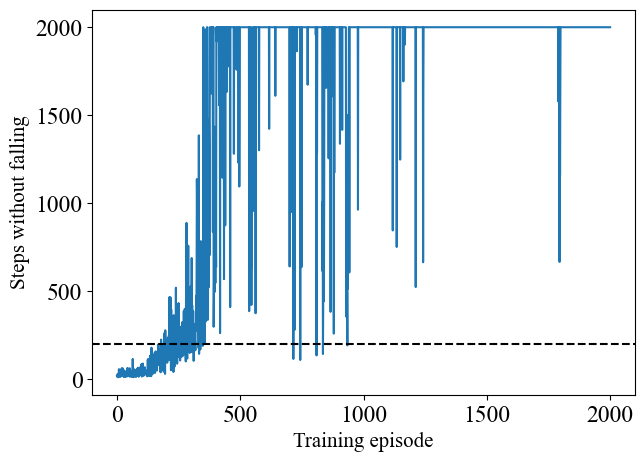

In [36]:
# Code created by me, should train the system in a similar fashion (hardcoded b for this problem)

# parameters

n_hidden = 0 # number of hidden layers
n_neurons = 64 # number of neurons per layer
lr = 0.002 # NN learning rate

gamma = 0.99 # gamma term in the sum
n_episode = 2000 # number of episodes to train for
n_steps = 200 # max length of each episode, ends earlier if it fails the task
b = 0.0 # baseline to subtract from the return

# initialize the variables

log_probs = [] # Will hold the log of the probs
rewards = [] # Will hold the rewards

recording = [] # Will hold the evolution of the training
recording2 = [] # Will hold the loss

# Step 1: define the environment

env = gym.make('CartPole-v0') # environment, the cartpole problem
in_dim = env.observation_space.shape[0] # 4 state parameters
out_dim = env.action_space.n # 2 action parameters

# Step 2: define the network

layers = [nn.Linear(in_dim, n_neurons), nn.ReLU()]

for i in range(n_hidden):
    
    layers.append(nn.Linear(n_neurons,n_neurons))
    layers.append(nn.ReLU())

layers.append(nn.Linear(n_neurons,out_dim))

pi = nn.Sequential(*layers)

opt = optim.Adam(pi.parameters(), lr)

# Step 3: train the policy

for eps in range(n_episode):
    
    state = env.reset()[0] # Reset the environment each episode
    
    for t in range(n_steps):
        
        # a) Perform the action
        
        pdparam = pi.forward(torch.from_numpy(state.astype(np.float32))) # forward pass
        pd = Categorical(logits = pdparam) # Obtain a probability distribution over the variables from the output
        action = pd.sample() # Choose an action from the policy distribution
        log_probss = pd.log_prob(action) # Obtain the log_prob of the chosen action
        log_probs.append(log_probss) # Save the log_prob for the loss
        
        # b) Obtain the result from the state
        
        state, reward, done, _, _ = env.step(action.item()) # Response from environment
        rewards.append(reward) # Save the reward for the loss
        if done:
            break
            
    # c) Obtain the loss
    
    T = len(rewards) # How long the episode was, max 200
    returnss = np.empty(T, dtype = np.float32) # To introduce the returns
    next_ret = 0.0
    for t in reversed(range(T)): # from last to first, we compute backwards the sum because of the return
        
        next_ret = rewards[t] + gamma*next_ret
        returnss[t] = next_ret
    
    b = np.mean(returnss) # Baseline: average of the returns of the episode
    returnss = returnss - b
    returnss = torch.tensor(returnss)
    log_props = torch.stack(log_probs)
    loss = -log_props*returnss # Gradient term, negative for max
    loss = torch.sum(loss)
    recording2.append(loss.item())
    opt.zero_grad()
    loss.backward() # backpropagation
    opt.step() # gradient descent (ascent)
    total_reward = sum(rewards)
    solved = total_reward > 195.0
    # clear memory
    log_probs = [] 
    rewards = [] 
    #print(f'Episode {eps}, loss: {loss}, \
    #total_reward: {total_reward}, solved: {solved}') # Training on screen
    recording.append(total_reward)
    
env.reset()
env.close()

print(np.mean(recording))
recording2 = np.array(recording)
print(np.mean(recording2[np.linspace(len(recording)-101,len(recording)-1,100).astype(int)]))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(recording)
axs.set_ylabel('Steps without falling', fontsize = 15)
axs.set_xlabel('Training episode', fontsize = 15)
axs.axhline(y=200,color='k',linestyle='--')
axs.tick_params(axis='both', labelsize = 17)
fig.savefig('DRL_REINFORCE_2.png', format='png', dpi=600)
plt.show()

168.10800000000003
198.13


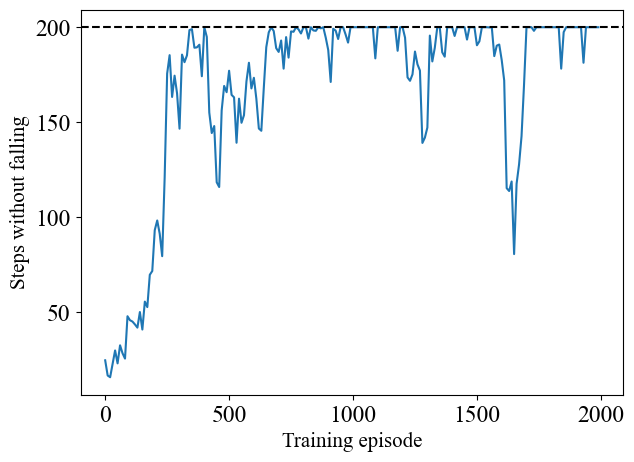

In [43]:
# Code created by me, should train the system in a similar fashion (hardcoded b for this problem)

# parameters

n_hidden = 0 # number of hidden layers
n_neurons = 64 # number of neurons per layer
lr = 0.002 # NN learning rate

gamma = 0.99 # gamma term in the sum
n_episode = 2000 # number of episodes to train for
n_steps = 200 # max length of each episode, ends earlier if it fails the task
b = 0.0 # baseline to subtract from the return

# initialize the variables

log_probs = [] # Will hold the log of the probs
rewards = [] # Will hold the rewards

recording = [] # Will hold the evolution of the training
recording2 = [] # Will hold the loss

# Step 1: define the environment

env = gym.make('CartPole-v0') # environment, the cartpole problem
in_dim = env.observation_space.shape[0] # 4 state parameters
out_dim = env.action_space.n # 2 action parameters

# Step 2: define the network

layers = [nn.Linear(in_dim, n_neurons), nn.ReLU()]

for i in range(n_hidden):
    
    layers.append(nn.Linear(n_neurons,n_neurons))
    layers.append(nn.ReLU())

layers.append(nn.Linear(n_neurons,out_dim))

pi = nn.Sequential(*layers)

opt = optim.Adam(pi.parameters(), lr)

# Step 3: train the policy

for eps in range(n_episode):
    
    state = env.reset()[0] # Reset the environment each episode
    
    for t in range(n_steps):
        
        # a) Perform the action
        
        pdparam = pi.forward(torch.from_numpy(state.astype(np.float32))) # forward pass
        pd = Categorical(logits = pdparam) # Obtain a probability distribution over the variables from the output
        action = pd.sample() # Choose an action from the policy distribution
        log_probss = pd.log_prob(action) # Obtain the log_prob of the chosen action
        log_probs.append(log_probss) # Save the log_prob for the loss
        
        # b) Obtain the result from the state
        
        state, reward, done, _, _ = env.step(action.item()) # Response from environment
        rewards.append(reward) # Save the reward for the loss
        if done:
            break
            
    # c) Obtain the loss
    
    T = len(rewards) # How long the episode was, max 200
    returnss = np.empty(T, dtype = np.float32) # To introduce the returns
    next_ret = 0.0
    for t in reversed(range(T)): # from last to first, we compute backwards the sum because of the return
        
        next_ret = rewards[t] + gamma*next_ret
        returnss[t] = next_ret
    
    b = np.mean(returnss) # Baseline: average of the returns of the episode
    returnss = returnss - b
    returnss = torch.tensor(returnss)
    log_props = torch.stack(log_probs)
    loss = -log_props*returnss # Gradient term, negative for max
    loss = torch.sum(loss)
    recording2.append(loss.item())
    opt.zero_grad()
    loss.backward() # backpropagation
    opt.step() # gradient descent (ascent)
    total_reward = sum(rewards)
    solved = total_reward > 195.0
    # clear memory
    log_probs = [] 
    rewards = [] 
    #print(f'Episode {eps}, loss: {loss}, \
    #total_reward: {total_reward}, solved: {solved}') # Training on screen
    #recording.append(total_reward)

    if eps%10 == 0:
        
        total_reward = np.zeros((10,))
        eval_rew = [] # Save the rewards for the current evaluation step
        
        for n in range(10):
            
            eval_rew = [] # Save the rewards for the current evaluation step
            state_ev = env.reset()[0]
            
            for arp in range(n_steps):

                # a) Perform the action
        
                pdparam = pi.forward(torch.from_numpy(state_ev.astype(np.float32))) # forward pass
                pd = Categorical(logits = pdparam) # Obtain a probability distribution over the variables from the output
                action_ev = pd.sample() # Choose an action from the policy distribution
        
                # b) Obtain the result from the state
        
                state_ev, reward_ev, done_ev, _, _ = env.step(action_ev.item()) # Response from environment
                eval_rew.append(reward_ev) # Save the reward for the loss
                env.render() # Creates the video
                
                if done_ev:
                    break
                    
            total_reward[n] = sum(eval_rew)
            eval_rew = [] # Save the rewards for the current evaluation step
            
        mean_reward = sum(total_reward)/10
        recording.append(mean_reward)
    
env.reset()
env.close()

print(np.mean(recording))
recording2 = np.array(recording)
print(np.mean(recording2[np.linspace(len(recording)-11,len(recording)-1,10).astype(int)]))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(np.linspace(0,len(recording)-1,len(recording))*10,recording)
axs.set_ylabel('Steps without falling', fontsize = 15)
axs.set_xlabel('Training episode', fontsize = 15)
axs.axhline(y=200,color='k',linestyle='--')
axs.tick_params(axis='both', labelsize = 17)
fig.savefig('DRL_REINFORCE_3.png', format='png', dpi=600)
plt.show()

172.16666666666666
96.45


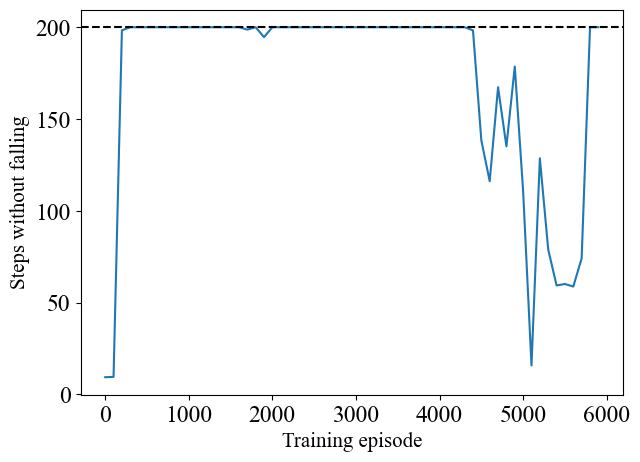

In [44]:
# DQN with double network and prioritized experience replay
# Note that it can only work on single action update

# Code created by me

# parameters

n_hidden = 1 # number of hidden layers
n_neurons = 64 # number of neurons per layer
lr0 = 0.01 # NN starting learning rate 0.01
lr1 = 0.0001 # NN final learning rate 0.0001
n_lr = 10000 # Steps until final learning rate
#gradient_clip = 0.5 # Clipping 0.5
counter = 0 # Resets when there has been 200 steps

n_training_steps = 6000 # N of full training steps
n_episode = 4 # N of steps to add to memory before training
n_steps = 200 # N of maximum steps in an episode in evaluation
n_batches = 4 # N of batches to use for training each time
n_batches_iter = 4 # N of updates to make per batch 8
waitr = 64 # Wait steps before starting to wait 32

mem_size = 10000 # N of examples that fit the memory 10000
l_batch = 64 # Size of each of the batches 32
gamma = 0.99 # Gamma of the training

#T0 = 5 # Starting value of the T 5
#T1 = 0.5 # Final value of the T 0.5
#n_T = 8000 # Time to reach the final value

eps0 = 1 # Starting value of the epsilon
eps1 = 0.01 # Final value of the epsilon
n_eps = 4000 # Time to reach the final value

F = 100 # Update time for target network

ee = 1/(mem_size*10) # Minimum probability for any example
eta = 1.5 # Exponent for the probability formula

# initialize the variables

results = [] # Store the current Q values for a batch
y = [] # Store the target values for a batch

recording = [] # Store the mean values of the runs evaluated every so many steps
recording2 = [] # Store the evolution of the loss

un_prob = [] # Store the unnormalized priorities, if needed
indexx = [] # Store the indices of the examples chosen in the batch, so we can update the probabilities

# Step 1: define the environment and memory

env = gym.make('CartPole-v0') # environment, the cartpole problem
in_dim = env.observation_space.shape[0] # 4 state parameters
out_dim = env.action_space.n # 2 action parameters

tree = SumTree(mem_size) # SumTree for the memory

# Step 2: define the NN of the Q function

layers = [nn.Linear(in_dim, n_neurons), nn.SELU()]

for i in range(n_hidden):
    
    layers.append(nn.Linear(n_neurons,n_neurons))
    layers.append(nn.SELU())
    #layers.append(nn.Dropout(p=0.2))

layers.append(nn.Linear(n_neurons,out_dim))

q_net = nn.Sequential(*layers) # Network for behavior in Q

opt = optim.Adam(q_net.parameters(), lr0)

losss = nn.MSELoss()

q_net_target = nn.Sequential(*layers) # Target network for Q

# Step 3: perform the training steps

state_exp = env.reset()[0] # Initialize the environment

for step in range(n_training_steps):
    
    if step%F == 0:
        
        q_net_target.load_state_dict(q_net.state_dict())
    
    opt = optim.Adam(q_net.parameters(), np.maximum(lr0 - step*(lr0-lr1)/n_lr,lr1)) # lr decay
    epsilon = np.maximum(eps0 - step*(eps0 - eps1)/(n_eps), eps1)
    #T = np.maximum(T0 - step*(T0 - T1)/(n_T), T1)
    
    # a) Gather the experiences through a number of steps, and save them to memory
    
    for i in range(n_episode):
        
        state0_exp = state_exp # Starting state for this step
        
        #action_exp,_ = boltz(state0_exp,q_net,T) # Obtain the action
        action_exp,_ = eps_greedy(state0_exp,q_net,epsilon) # Obtain the action
        
        #print(q_net.forward(torch.from_numpy(state0.astype(np.float32))))
        
        state_exp, reward_exp, done_exp, _, _ = env.step(action_exp.item()) # Obtain the rewards and new state
        
        # Save to memory
        
        q_prior = q_net.forward(torch.from_numpy(state0_exp.astype(np.float32)))[action_exp.item()]
        
        if done_exp:
            
            y_prior = torch.tensor(0.0)
            
        else:
            
            action2 = torch.argmax(q_net.forward(torch.from_numpy(state_exp.astype(np.float32))))
            y_prior = reward_exp + gamma*q_net_target.forward(torch.from_numpy(state_exp.astype(np.float32)))[action2.item()]
            
        prior = (np.abs(y_prior.detach().numpy()-q_prior.detach().numpy())+ee)**eta
        
        un_prob.append(prior) # Store the priority, used later to obtain the probability
        
        tree.add(prior/np.sum(np.array(un_prob)),[state0_exp,action_exp,reward_exp,state_exp,done_exp])
        
        # Check if it needs to reset the run
        
        counter = counter + 1
        
        if done_exp:
            
            state_exp = env.reset()[0]
            
        if counter == n_steps - 1:
            
            state_exp = env.reset()[0]
            counter = 0
    
    if step > waitr-1:
        
        # b) Select a number of batches from memory, and train using them
    
        for i in range(n_batches):
        
            # Create the batch
        
            batch_states0 = [] # List to store the batch previous states
            batch_action = [] # List to store the batch taken actions
            batch_reward = [] # List to store the batch obtained rewards
            batch_states2 = [] # List to store the batch next states
            batch_dones = [] # List to store the batch done flags
            batch_indices = [] # List to store the batch indices of chosen examples
            batch_indices2 = [] # List to store the batch indices of chosen examples, v2
            
            segment = tree.total()/l_batch
            
            for i in range(l_batch):
                
                a = segment*i
                b = segment*(i+1)
                
                s = np.random.uniform(a,b)
                (idx, p, data, dataIdx) = tree.get(s)
                
                batch_states0.append(data[0])
                batch_action.append(data[1])
                batch_reward.append(data[2])
                batch_states2.append(data[3])
                batch_dones.append(data[4])
                batch_indices.append(dataIdx)
                batch_indices2.append(idx)
            
            # Perform the training updates of this batch
        
            for j in range(n_batches_iter):
            
                for a in range(l_batch):
                
                    # Obtain the Q values for the states in the batch, save them as current output of net
                
                    q_val_current = q_net.forward(torch.from_numpy(batch_states0[a].astype(np.float32)))
                    results.append(q_val_current)
                
                    # Obtain the target Q values (only the corresponding action will be changed)
                
                    objc = torch.clone(q_val_current)
                
                    with torch.no_grad():
                        
                        if batch_dones[a]:
                            
                            objc[batch_action[a].item()] = torch.tensor(0.0)
                            
                        else:
                            
                            q_val_next = q_net.forward(torch.from_numpy(batch_states2[a].astype(np.float32)))
                            action_adv = torch.argmax(q_val_next)
                            q_val_next_target = q_net_target.forward(torch.from_numpy(batch_states2[a].astype(np.float32)))
                            objc[batch_action[a].item()] = batch_reward[a] + gamma*q_val_next_target[action_adv.item()]
                    
                    del(un_prob[batch_indices[a]])
                    un_prob.append((np.abs(objc[batch_action[a].item()].detach().numpy()-q_val_current[batch_action[a].item()].detach().numpy())+ee)**eta/np.sum(np.array(un_prob)))
                    
                    tree.update(batch_indices2[a], (np.abs(objc[batch_action[a].item()].detach().numpy()-q_val_current[batch_action[a].item()].detach().numpy())+ee)**eta/np.sum(np.array(un_prob)))
    
                    y.append(objc)
                
                # Obtain the loss of this batch
            
                loss = losss(torch.stack(results),torch.stack(y).detach())
                recording2.append(loss.item())
            
                # Update the network
            
                opt.zero_grad()
                loss.backward() # backpropagation
                #torch.nn.utils.clip_grad_norm_(q_net.parameters(),gradient_clip)
                opt.step() # gradient descent
            
                # Reset memory
            
                results = [] # Reset memory of the Q values
                y = [] # Reset memory of the target Q values
                
    env.state = env.unwrapped.state = state_exp
            
    # Evaluate every 100 steps, a mean of 10 runs
            
    if step%100 == 0:
        
        total_reward = np.zeros((10,))
        eval_rew = [] # Save the rewards for the current evaluation step
        
        for n in range(10):
            
            eval_rew = [] # Save the rewards for the current evaluation step
            state_ev = env.reset()[0]
            
            for arp in range(n_steps):
                
                state0_ev = state_ev # Starting state for this step
                action_ev, _ = eps_greedy(state0_ev,q_net,0) # Obtain the action
                state_ev, reward_ev, done_ev, _, _ = env.step(action_ev.item()) # Obtain the rewards and new state
                
                eval_rew.append(reward_ev)
                
                #env.render()
                
                if done_ev:
                    
                    break
                    
            total_reward[n] = sum(eval_rew)
            eval_rew = [] # Save the rewards for the current evaluation step
            
        mean_reward = sum(total_reward)/10
        recording.append(mean_reward)

env.reset()
env.close()

print(np.mean(recording))
recording2 = np.array(recording)
print(np.mean(recording2[np.linspace(len(recording)-11,len(recording)-1,10).astype(int)]))

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(np.linspace(0,len(recording)-1,len(recording))*100,recording)
axs.set_ylabel('Steps without falling', fontsize = 15)
axs.set_xlabel('Training episode', fontsize = 15)
axs.axhline(y=200,color='k',linestyle='--')
axs.tick_params(axis='both', labelsize = 17)
fig.savefig('DRL_DDQN_1.png', format='png', dpi=600)
plt.show()

1999.9


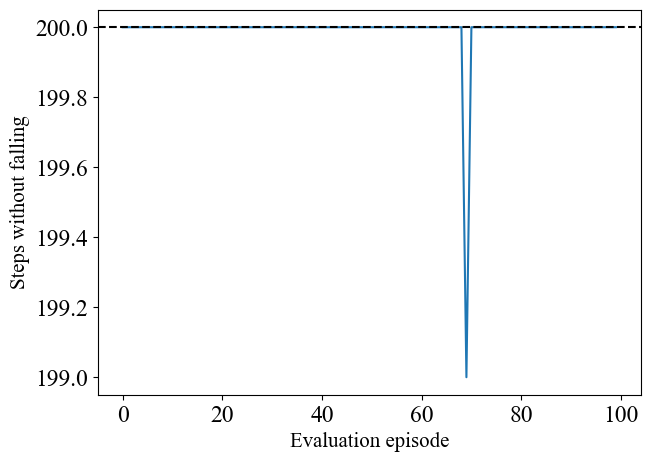

In [45]:
# PPO

# Step 1: pre-allocating, loading and previous steps

seed = 42 # Fix the random seed

random.seed(seed) # Seed the random library
torch.manual_seed(seed) # Seed the pytorch library
np.random.seed(int(seed)) # Seed the numpy library

torch.backends.cudnn.deterministic = True # Set cuda parameters
torch.backends.cudnn.benchmark = False    # Set cuda parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

n_eval_episodes = 200 # Number of steps per evaluation episode
N_timesteps = int(4000*200) # Number of steps (4000 episodes of 32 steps each)

torch.set_num_threads(1) # Set pytorch num threads to 1 for faster training

# Step 2: set the environment and the model hyperparameters

our_env = gym.make('CartPole-v0') # Set environment 

# Hyperparameters chosen by optuna

n_steps = 200                                                   # Steps per episode
gamma = 1.0 - 0.00012343188973544484                            # Discount factor for RL
learning_rate = 6.24161237241945e-05                            # Learning rate
gae_lambda = 0.8714387482390391                                 # GAE exponential factor
max_grad_norm = 4.042358248277151                               # Maximum gradient
net_arch = {"pi": [100,100,100,100], "vf": [100,100,100,100]}   # Network architecture (actor and critic)
activation_fn = nn.SELU                                         # Activation function

# Hyperparameter dictionary

DEFAULT_HYPERPARAMS = {
"policy": "MlpPolicy",
"env": our_env,
"device": device
}

Hyperparams = {
"n_steps": n_steps,
"gamma": gamma,
"learning_rate": learning_rate,
"max_grad_norm": max_grad_norm,
"gae_lambda": gae_lambda,
"batch_size": n_steps,
"policy_kwargs": {
    "net_arch": net_arch,
    "activation_fn": activation_fn,
    }
}

kwargs = DEFAULT_HYPERPARAMS.copy() # Start the dictionary with the default ones
kwargs.update(Hyperparams)          # Add the ones found by optuna 

# Step 3: train the model

model = PPO(**kwargs) # Create the model, using the previous hyperparams

model.learn(N_timesteps) # Train the model
    
model.env.close() # Close the env

# Now we run a series of runs to see how well it could learn

total_reward = np.zeros((100,))
eval_rew = [] # Save the rewards for the current evaluation step
        
for n in range(100):
            
    eval_rew = [] # Save the rewards for the current evaluation step
    state_ev = env.reset()[0]
            
    for arp in range(n_steps):
                
        state0_ev = state_ev # Starting state for this step
        action_ev, _ = eps_greedy(state0_ev,q_net,0) # Obtain the action
        state_ev, reward_ev, done_ev, _, _ = env.step(action_ev.item()) # Obtain the rewards and new state
                
        eval_rew.append(reward_ev)
                                
        if done_ev:
                    
            break
                    
    total_reward[n] = sum(eval_rew)
    eval_rew = [] # Save the rewards for the current evaluation step
            
mean_reward = sum(total_reward)/10

print(mean_reward)

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(total_reward)
axs.set_ylabel('Steps without falling', fontsize = 15)
axs.set_xlabel('Evaluation episode', fontsize = 15)
axs.axhline(y=200,color='k',linestyle='--')
axs.tick_params(axis='both', labelsize = 17)
fig.savefig('DRL_PPO_1.png', format='png', dpi=600)
plt.show()